### Exercises

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import pandas as pd
from math import pi
import seaborn as sns

# """
# if True:      
#   # Clone repository with example images 
#   !rm -rf fyp2021p3g14
#   !git clone https://github.com/hugzito/fyp2021p3g14.git
# """
#Unsure if needed ^^^^ could run without

In [330]:
im = plt.imread('../data/example_image/ISIC_0000013.jpg')
plt.imshow(im);

FileNotFoundError: [Errno 2] No such file or directory: '../data/example_image/ISIC_0000013.jpg'

(2016, 3024, 3) uint8


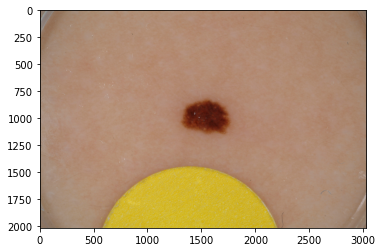

Error in callback <function flush_figures at 0x7f4388e4b830> (for post_execute):


KeyboardInterrupt: 

In [ ]:
idk = plt.imread("../data/example_image/ISIC_0001852.jpg")
plt.imshow(idk)
print(idk.shape,idk.dtype)
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(5, 3))
axes[0].imshow(idk[:,:,0], cmap="gray")
axes[1].imshow(idk[:,:,1], cmap="gray")
axes[2].imshow(idk[:,:,2], cmap="gray")
fig.tight_layout()
mask2=plt.imread('../data/example_segmentation/ISIC_0001852_segmentation.png')
plt.imshow(mask2, cmap='gray');
img1 = Image.open('../data/example_image/ISIC_0001852.jpg')
img2 = Image.open('../data/example_segmentation/ISIC_0001852_segmentation.png')
img2.paste(img1, (0,0), mask = img2) 

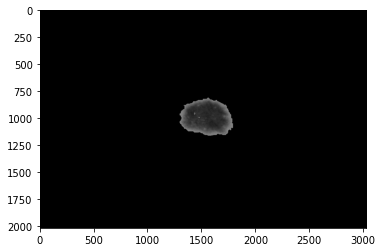

In [ ]:
plt.imshow(mask2, cmap='gray');
plt.imshow(img2, cmap='gray');

In [ ]:
print(im.shape)
print(im.dtype)

(2016, 3024, 3)
uint8


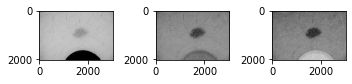

In [ ]:
#plotting all the colors
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(5, 3))
axes[0].imshow(im[:,:,0], cmap="gray")
axes[1].imshow(im[:,:,1], cmap="gray")
axes[2].imshow(im[:,:,2], cmap="gray")
fig.tight_layout()

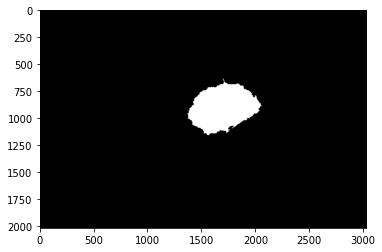

In [ ]:
mask=plt.imread('../data/example_segmentation/ISIC_0001769_segmentation.png')
plt.imshow(mask, cmap='gray');

In [ ]:
img1 = Image.open('../data/example_image/ISIC_0001769.jpg')
img2 = Image.open('../data/example_segmentation/ISIC_0001769_segmentation.png')

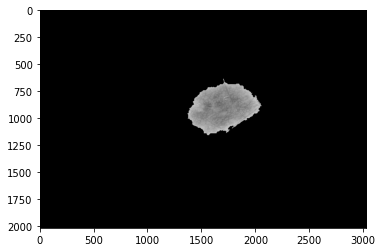

In [ ]:
# Overlay - more options such as transparency should be available here  
img2.paste(img1, (0,0), mask = img2) 
  
# Display 
#img2.show()  # Opens a file on your computer with the image
plt.imshow(img2, cmap='gray');

In [327]:
# Alternative: replace the non-lesion pixels

img1 = im.copy()
img1[mask==0]
  
# Display 
plt.imshow(img1);

NameError: name 'im' is not defined

In [ ]:
#get a color from within the lesion
print(im[1000,1800,:])

[156  92  56]


## Project 3

### Task 0

In [ ]:
"""
# Get code and images

if True:      #A weird trick needed for Google Colab
  # Clone repository with images/code
  !rm -rf fyp2021p3
  !git clone https://github.com/vcheplygina/fyp2021p3.git


import matplotlib.pyplot as plt
import numpy as np

im = plt.imread('fyp2021p3/data/example_image/ISIC_0001769.jpg')
mask=plt.imread('fyp2021p3/data/example_segmentation/ISIC_0001769_segmentation.png')
"""


"\n# Get code and images\n\nif True:      #A weird trick needed for Google Colab\n  # Clone repository with images/code\n  !rm -rf fyp2021p3\n  !git clone https://github.com/vcheplygina/fyp2021p3.git\n\n\nimport matplotlib.pyplot as plt\nimport numpy as np\n\nim = plt.imread('fyp2021p3/data/example_image/ISIC_0001769.jpg')\nmask=plt.imread('fyp2021p3/data/example_segmentation/ISIC_0001769_segmentation.png')\n"

3.545708406819518


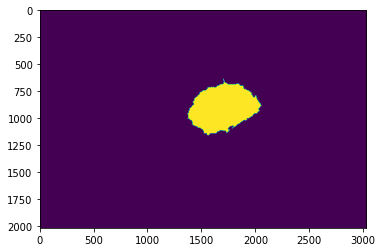

In [ ]:

#Total size of the image
total = mask.shape[0] * mask.shape[1] 

#Size of mask only
area = np.sum(mask)

#As percentage
print(area/total*100)

plt.imshow(mask);


In [ ]:
# A way to measure width/height 

pixels_in_col = np.max(np.sum(mask, axis=0))
# pixels_in_row = 

print(pixels_in_col)

469.0


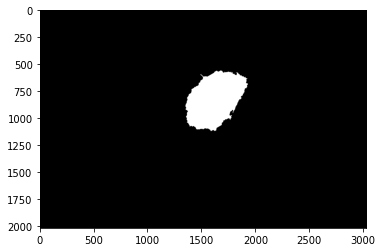

In [ ]:
# Diameter at an angle
#!pip install scikit-image
from skimage import transform

rot_im = transform.rotate(mask, 30)
plt.imshow(rot_im, cmap='gray');


In [ ]:
from skimage import morphology

#Structural element, that we will use as a "brush" on our mask
struct_el = morphology.disk(20)

print(struct_el)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


216160.0
177421


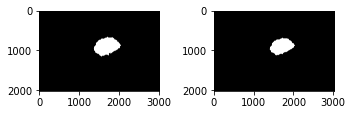

In [ ]:
mask_eroded = morphology.binary_erosion(mask, struct_el)

# Show side by side

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5, 3))
axes[0].imshow(mask, cmap='gray')
axes[1].imshow(mask_eroded, cmap='gray')
fig.tight_layout()

# Verify it's smaller
print(area)
print(np.sum(mask_eroded))


38739.0


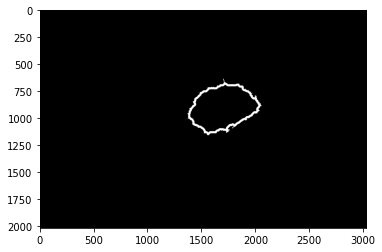

In [ ]:
# Subtract the two masks from each other to get the border/perimeter

image_perimeter = mask - mask_eroded

plt.imshow(image_perimeter, cmap='gray') #The perimeter is very thin so it might be difficult to see on the screen

#What is the length? 
print(np.sum(image_perimeter))


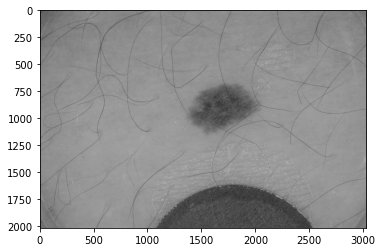

In [ ]:
# Work with color image as grayscale

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

gray = rgb2gray(im)
plt.imshow(gray, cmap='gray')



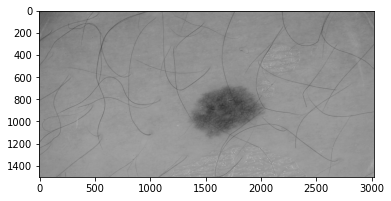

In [ ]:
# Let's get rid of the marker
gray2 = gray[0:1500,:]
plt.imshow(gray2, cmap='gray')

mask2 = mask[0:1500,:]


KeyboardInterrupt: 

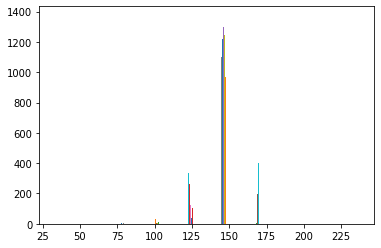

In [ ]:
#Look at intensities of image
# plt.hist(gray2)


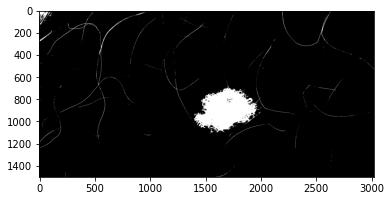

In [ ]:
# Threshold
mymask = gray2 < 120  #Pixels with lower intensities will be equal to 1 in the mask
plt.imshow(mymask, cmap='gray')

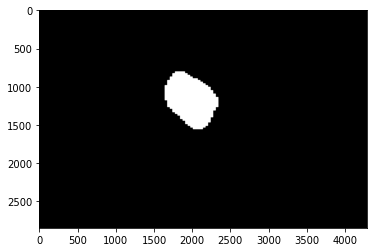

In [ ]:
# There is some noise, we can get rid of it by morphological operators

from skimage.morphology import opening

# Opening = first EROSION, then DILATION 

# Erosion will get rid of hairs but also make the lesion smaller. 
# Dilation will restore the lesion (but not the hairs)

struct_el = morphology.disk(5)
opened = opening(mask2, struct_el)

plt.imshow(opened, cmap='gray')

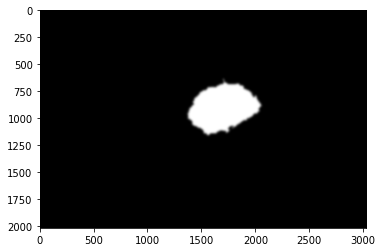

In [ ]:
# Gaussian filtering (blur)

from skimage import filters

blurred = filters.gaussian(mask,sigma=10)

plt.imshow(blurred, cmap='gray')

#What kind of values are in the image now?



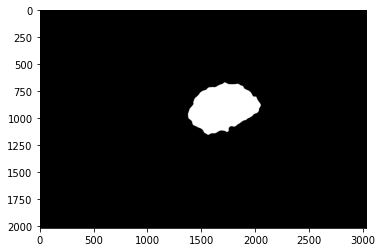

In [ ]:
# Threshold again

mask2 = blurred > 0.5
plt.imshow(mask2, cmap='gray')


/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  This is separate from the ipykernel package so we can avoid doing imports until


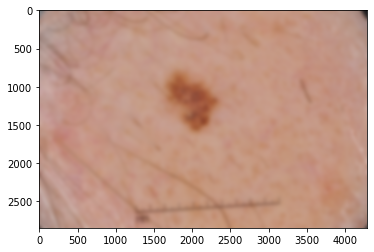

In [ ]:
# Blur color image - this could be useful for measuring color (variability)

blurred = filters.gaussian(im,sigma=25)

plt.imshow(blurred)


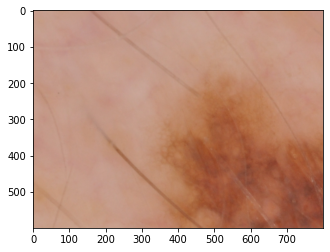

In [ ]:
# Many examples in https://scikit-image.org/docs/dev/api/skimage.feature.html 

# Crop image first

im2 = im[600:1200,1300:2100,:]
mask2 = mask[600:1200,1300:2100]


plt.imshow(im2)


In [ ]:
# Gaussian features recently available (might need to update version)

# Example segmentation for microscopy image: https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_trainable_segmentation.html#sphx-glr-auto-examples-segmentation-plot-trainable-segmentation-py 

#!pip install scikit-image==0.18.0

In [ ]:


from skimage import feature
from functools import partial 

#Extract feature images
feat_im = feature.multiscale_basic_features(im2, multichannel=True, intensity=False, edges=False, texture=True, sigma_min = 2, sigma_max = 8)
print(feat_im.shape)


(600, 800, 18)


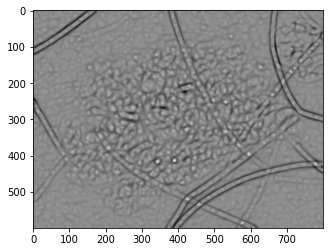

In [ ]:

plt.imshow(feat_im[:,:,3], cmap='gray')


[    18     28     68   1425  23048 278344 115381  40369  10356   3961
   2522   2104   1297    671    331     77]


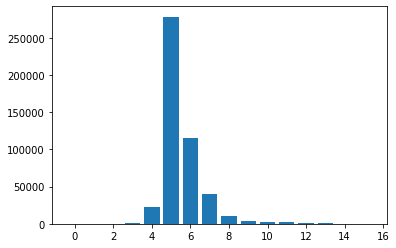

In [ ]:
# We measured X features for every pixel in the image - this is good for segmentation, but not image classification yet

# For classification we need to aggregate the outputs for each feature type into one vector

feat_vec, bin_edges = np.histogram(feat_im[:,:,8], bins=16)

plt.bar(np.arange(0,16), feat_vec)
print(feat_vec)

In [ ]:
# Determine bins based on intensities instead... 
# plt.hist(feat_im[:,:,8], bins='auto')     # Very slow for large images

flat_im = np.ndarray.flatten(feat_im[:,:,8])
flat_mask = np.ndarray.flatten(mask2)

# Only pixels inside the mask
flat_im = flat_im[flat_mask==1]

quantile_bins = np.quantile(flat_im, np.arange(0,1,0.1))

# Bins have different widths
print(quantile_bins)

#feat_vec, bin_edges = np.histogram(flat_im, bins=quantile_bins)
#print(feat_vec)

[-2.26808526e-03 -1.80511163e-04 -4.01187353e-05  6.72517315e-05
  1.68621261e-04  2.69471187e-04  3.78192734e-04  5.01193322e-04
  6.44937181e-04  8.58059071e-04]


## Feature Analysis

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import pandas as pd
from math import pi
import seaborn as sns
import os
from scipy import ndimage

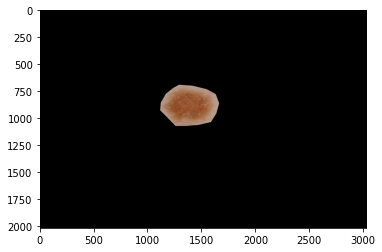

In [ ]:
#Test Image
test = plt.imread("../data/example_image/ISIC_0003462.jpg")
plt.imshow(test)

#Lesion Segmentation
mask_test=plt.imread("../data/example_segmentation/ISIC_0003462_segmentation.png")
test1 = test.copy()
test1[mask_test==0] = 0
plt.imshow(test1)

Code to ignore lesions that are clipped by the image border

In [ ]:
segmentation_list = list()
for segmentation in os.listdir("../data/example_segmentation"):
    mask_ID = plt.imread("../data/example_segmentation" + "/" + segmentation)
    #top border + bottom border + left border + right border
    border_sum = sum(mask_ID[0]) + sum(mask_ID[-1]) + sum([i[0] for i in mask_ID]) + sum([i[-1] for i in mask_ID])
    if border_sum == 0:
        segmentation_list.append(segmentation)
#To-do: implement the filtered segmentation list into 
#the file for loops for the various feature tests

How symmetrical is the lesion?

In [ ]:
##Area VS Perimeter
#already done below with "Compactness"

In [188]:
##Determining how symmetrical the lesion is

def folded_overlap(mask_ID):
    #Finds center-point
    borders = np.where(mask_ID == 1)
    up, down, left, right = max(borders[0]), min(borders[0]), min(borders[1]), max(borders[1])
    center = ((up+down) //2, (left + right) //2)

    #compares overlap between the 2 horizontal halves of the lesion
    half1 = mask_ID[down:up, left:center[1]]
    half1 = np.flip(half1,1)
    if (right-left)%2 == 0: #can't compare 2 images of different sizes
        half2 = mask_ID[down:up, center[1]:right]
    else:
        half2 = mask_ID[down:up, center[1]+1:right]
    overlap_h = np.logical_and(half1==1, half2==1)

    half_h_average_sum = (np.sum(half1) + np.sum(half2)) / 2
    overlap_h_sum = np.sum(overlap_h)
    overlap_h_percentage = overlap_h_sum / half_h_average_sum

    #the 2 vertical halves
    half3 = mask_ID[down:center[0], left:right]
    half3 = np.flip(half3,0)
    if (up-down)%2 == 0: #can't compare 2 images of different sizes
        half4 = mask_ID[center[0]:up, left:right]
    else:
        half4 = mask_ID[center[0]+1:up, left:right]
    overlap_v = np.logical_and(half3==1, half4==1)
    half_v_average_sum = (np.sum(half3) + np.sum(half4)) / 2
    overlap_v_sum = np.sum(overlap_v)
    overlap_v_percentage = overlap_v_sum / half_v_average_sum

    #horizontal fold, vertical fold
    return (overlap_h_percentage+ overlap_v_percentage)/2

mask_ID = plt.imread("../data/example_segmentation/ISIC_0001769_segmentation.png")
print(folded_overlap(mask_ID))

0.838356465509878


In [193]:
import scipy.ndimage
#Runs the overlap function for several images and their rotations.
#20-50 seconds per image (5 rotations).
#Need to create a dataframe with the simetry values for img and export it to a csv file
temp_list = list() #gets inserted into the dataframe eventually

# degrees = [15]*5 #or [10]*8 or [30]*2 (one less rotation than what sums to 90 degrees)
for filename in os.listdir("../data/example_segmentation"):
    mask_ID = plt.imread("../data/example_segmentation" + "/" + filename)
    dict1 = {}
    dict1.update({"id":filename[:-17],"simetry":folded_overlap(mask_ID)}) 
    temp_list.append(dict1)
    #Can append max(overlap_list) to find the largest overlap percentage for the image
    #or the mean(overlap_list) to get the average overlap percentage
    #along various folds rather than just the ideal one.
df1 = pd.DataFrame(temp_list)  
df1

,id,simetry
0,ISIC_0001769,0.838356
1,ISIC_0001852,0.914855
2,ISIC_0001871,0.819148
3,ISIC_0003462,0.960336
4,ISIC_0003539,0.678271
...,...,...
145,ISIC_0015443,0.939804
146,ISIC_0015445,0.412264
147,ISIC_0015483,0.953377
148,ISIC_0015496,0.867868


In [ ]:
##Check for how close the lesion is to a circle (oval too?). 
#draw lines from center to various points on the edge, then find
#average difference between length of lines?

What are the qualities of the border? (Smoothness, colors, ?)

In [ ]:
##Smoothness
#Sort of difficult to check for since the segmentation mask specifically
#doesn't try to determine the exact contour of the lesion, it just tries
#to encapsulate it. Might need to analyze shade changes between skin/lesion
#to really get the exact shape.

#is connected to compactness, can be argued to be used instead

In [ ]:
##Colors
#Any changes in the coloration of the edges of the lesion compared to the
#inside of it?

Any notable characteristics in regards to the colors?

In [ ]:
##Isolate for relative color due to differences in lighting?

In [ ]:
##Color of lesion
#Maybe keratosis lesions are darker?

In [ ]:
##Color uniformity of lesion
#Could use edge detection to see how much/where the color variation is 
#throughout the image and then sum the total edges. Would give an idea
#of the roughness and/or color texture of the lesion.

#Could also check how "spotted" a lesion is by looking at the colors.

In [197]:
#Loading in the features csv files which can be used to calculate the compactness of the lesions
features = pd.read_csv (r'../features/features.csv')
truth = pd.read_csv(r'../data/ISIC-2017_Training_Part3_GroundTruth.csv')


In [326]:
#making a coloumn to see if lesion is healthy
# truth["Sick"] = truth["melanoma"] + truth["seborrheic_keratosis"]
#making sure that there are no other values than 1 and 0
import os
# truth["Sick"].unique()
truth["id"] = truth["image_id"]
tr_melanoma = truth[truth["melanoma"]>0]
nr_rows_melanoma = len(tr)
tr_non_melanoma = truth[truth["melanoma"]<1][:nr_rows_melanoma]
melanoma_d = tr_melanoma.append(tr_non_melanoma)
melanoma_d = melanoma_d.drop(["image_id","seborrheic_keratosis"],axis=1)
# d = pd.merge(truth,melanoma_d,on="id",how="left")
# a = truth[~truth["id"].isin(melanoma_d["id"])]
# for i in a["id"]:
#     file_path = "../data/ISIC-2017_Training_Data/" + i+".jpg"
#     os.remove(file_path)


melanoma_d

,melanoma,id
2,1.0,ISIC_0000002
4,1.0,ISIC_0000004
12,1.0,ISIC_0000013
21,1.0,ISIC_0000022
25,1.0,ISIC_0000026
...,...,...
498,0.0,ISIC_0002871
499,0.0,ISIC_0002879
500,0.0,ISIC_0002885
501,0.0,ISIC_0002948


In [217]:
def measure_compactness(mask):
    # Measure area: the sum of all white pixels in the mask image
    area = np.sum(mask)

    # Measure perimeter: first find which pixels belong to the perimeter.
    struct_el = morphology.disk(1)
    mask_eroded = morphology.binary_erosion(mask, struct_el)
    image_perimeter = mask - mask_eroded

    # Now we have the perimeter image, the sum of all white pixels in it
    perimeter = np.sum(image_perimeter)
    compactness = (perimeter**2)/(4*pi*area)
    return compactness


In [224]:

from skimage import morphology
from scipy.spatial.distance import cdist
from scipy.stats.stats import mode
list_x=[]
for i in melanoma_d["id"]:
    print(i)
    df_comp = pd.DataFrame( columns=["id","compactness"])
    mask = plt.imread("../data/ISIC-2017_Training_Data_mask" + "/" + i+"_segmentation.png")
    dict1 = {}
    
    # get input row in dictionary format
    # key = col_name
    dict1.update({"id":i,"compactness":measure_compactness(mask)}) 

    list_x.append(dict1)

df_comp = pd.DataFrame(list_x)   
# im = plt.imread('../data/example_image/ISIC_0012288.jpg')
# plt.imshow(im);


ISIC_0000002
ISIC_0000004
ISIC_0000013
ISIC_0000022
ISIC_0000026
ISIC_0000029
ISIC_0000030
ISIC_0000031
ISIC_0000035
ISIC_0000036
ISIC_0000040
ISIC_0000043
ISIC_0000046
ISIC_0000049
ISIC_0000054
ISIC_0000056
ISIC_0000074
ISIC_0000077
ISIC_0000078
ISIC_0000139
ISIC_0000140
ISIC_0000141
ISIC_0000142
ISIC_0000143
ISIC_0000145
ISIC_0000146
ISIC_0000147
ISIC_0000148
ISIC_0000149
ISIC_0000150
ISIC_0000151
ISIC_0000152
ISIC_0000153
ISIC_0000154
ISIC_0000155
ISIC_0000156
ISIC_0000157
ISIC_0000159
ISIC_0000160
ISIC_0000161
ISIC_0000162
ISIC_0000163
ISIC_0000164
ISIC_0000165
ISIC_0000166
ISIC_0000167
ISIC_0000169
ISIC_0000171
ISIC_0000172
ISIC_0000174
ISIC_0000176
ISIC_0000276
ISIC_0000277
ISIC_0000278
ISIC_0000281
ISIC_0000282
ISIC_0000283
ISIC_0000285
ISIC_0000288
ISIC_0000289
ISIC_0000290
ISIC_0000292
ISIC_0000293
ISIC_0000294
ISIC_0000295
ISIC_0000297
ISIC_0000298
ISIC_0000299
ISIC_0000300
ISIC_0000301
ISIC_0000302
ISIC_0000303
ISIC_0000306
ISIC_0000307
ISIC_0000310
ISIC_0000311
ISIC_0000313

ISIC_0000416
ISIC_0000418
ISIC_0000419
ISIC_0000421
ISIC_0000423
ISIC_0000425
ISIC_0000426
ISIC_0000427
ISIC_0000431
ISIC_0000433
ISIC_0000436
ISIC_0000439
ISIC_0000442
ISIC_0000443
ISIC_0000447
ISIC_0000448
ISIC_0000449
ISIC_0000451
ISIC_0000453
ISIC_0000455
ISIC_0000456
ISIC_0000457
ISIC_0000458
ISIC_0000460
ISIC_0000461
ISIC_0000465
ISIC_0000467
ISIC_0000468
ISIC_0000470
ISIC_0000471
ISIC_0000473
ISIC_0000474
ISIC_0000475
ISIC_0000476
ISIC_0000478
ISIC_0000479
ISIC_0000480
ISIC_0000481
ISIC_0000483
ISIC_0000485
ISIC_0000486
ISIC_0000488
ISIC_0000489
ISIC_0000490
ISIC_0000491
ISIC_0000492
ISIC_0000493
ISIC_0000494
ISIC_0000495
ISIC_0000496
ISIC_0000498
ISIC_0000499
ISIC_0000500
ISIC_0000501
ISIC_0000503
ISIC_0000504
ISIC_0000505
ISIC_0000506
ISIC_0000507
ISIC_0000508
ISIC_0000509
ISIC_0000510
ISIC_0000514
ISIC_0000515
ISIC_0000523
ISIC_0000524
ISIC_0000525
ISIC_0000527
ISIC_0000528
ISIC_0000529
ISIC_0000530
ISIC_0000532
ISIC_0000534
ISIC_0000535
ISIC_0000536
ISIC_0000538
ISIC_0000539

In [225]:
df_comp

,id,compactness
0,ISIC_0000002,1.437692
1,ISIC_0000004,0.900214
2,ISIC_0000013,1.103873
3,ISIC_0000022,1.005982
4,ISIC_0000026,0.934538
...,...,...
743,ISIC_0002871,0.907762
744,ISIC_0002879,0.896104
745,ISIC_0002885,0.899957
746,ISIC_0002948,1.669070


In [ ]:
#useless since we added it as a coloumn to the features dataset instead
def Compact(ID):
    """Function that takes in the ID for a lesion and calculates the compactness with the formula perimeter^2/4*pi*Area
    uses the features dataframe so make sure it is loaded in before using the function
    """
    selected = features[features["id"] == str(ID)]
    l = selected["perimeter"]
    A = selected["area"]
    return (l**2)/(4*pi*A)


In [ ]:
#index number 145 in the dataset
Compact("ISIC_0015443")


145    1.551412
dtype: float64

In [57]:
#the compactness can be used to check B of the ABC part the larger the value the more jagged edge the lesion have 
#(possibly also assymetry to a certain extend)

#could be used to create a scatter plot together with something like the assymetry to decide what method would be best
#to filter the
features["Compactness"] = (features["perimeter"]**2)/(4*pi*features["area"])
features

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [183]:
#trying to combine the two datasets
combined = truth
combined["compactness"] = features["Compactness"]
combined["area"] = features["area"]
combined["perimeter"] = features["perimeter"]

#plotting to see if anything can be seen visually
#the sick have higher compactness


KeyError: 'Compactness'

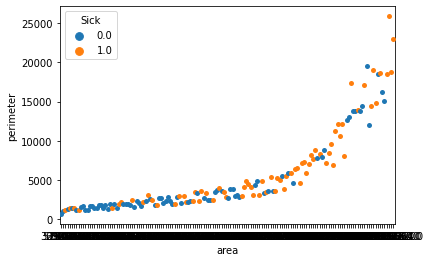

In [ ]:
sns.swarmplot(x = "area", y = "perimeter", hue = "Sick", data=combined);

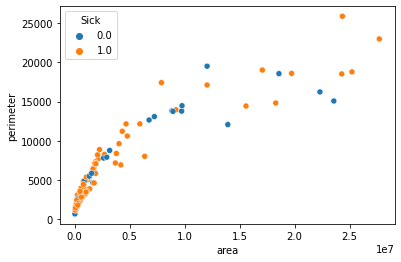

In [ ]:
#vizualising the area and perimeter to see if anything is noticable
sns.scatterplot(x = "area", y = "perimeter", hue = "Sick", data=combined);

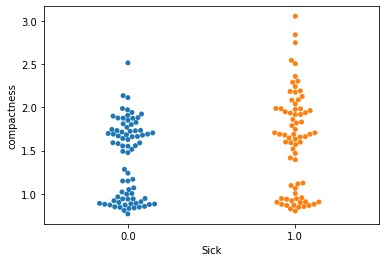

In [ ]:
#plotting the compactness and sickness to see if anything notable can be observed
sns.swarmplot(x = "Sick", y = "compactness", data=combined);

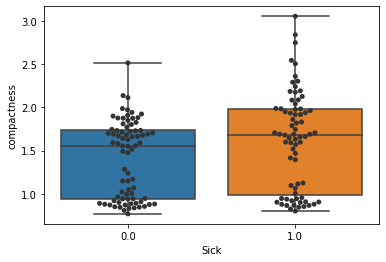

In [ ]:
sns.boxplot(x="Sick", y="compactness", data=combined, whis=np.inf)
sns.swarmplot(x = "Sick", y = "compactness", data=combined,color=".2");

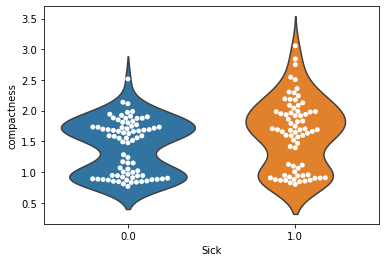

In [ ]:
sns.violinplot(x="Sick", y="compactness", data=combined, inner=None)
sns.swarmplot(x = "Sick", y = "compactness", data=combined, color = "white");

In [230]:
features2 = pd.read_csv (r'../features/more_features.csv')
f2 = features2.drop("sex",axis=1)
f2 = f2.rename(columns={"image_id":"id"})


In [4]:
import cv2
def extract_color_histogram(img, n_bins=8):
    """Extract Color histogram of an image.
    :param img: ndarray, BGR image
    :return feature: ndarray, contains n_bins*n_bins*n_bins HSV histogram features of the image
    """
    
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV) # convert the image to HSV color-space
    hist  = cv2.calcHist([hsv], [0, 1, 2], None, [n_bins, n_bins, n_bins], [0, 180, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    feature = hist.flatten()
    return feature

In [54]:
def resize_image(img, img_size):
    """Pad and Resize image to a fixed size (img_size, img_size)
    :param img: ndarray, BGR image
    :param img_size: int, size to resize images.
    :return img_resized: padded and resized image
    """
    
    # pad image to the max dimension
    top = (max(img.shape[:2]) - img.shape[0])//2
    bottom = max(img.shape[:2]) - img.shape[0] - top
    left = (max(img.shape[:2]) - img.shape[1])//2
    right = max(img.shape[:2]) - img.shape[1] - left
    img_padded = cv2.copyMakeBorder(img, top, bottom, left, right,cv2.BORDER_CONSTANT, value=[0, 0, 0])
    
    # resize image
    img_resized = cv2.resize(img_padded, (img_size, img_size))
    return img_resized

In [398]:
#Color feature extraction
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import cv2
from skimage import io
import os
from skimage import morphology
from sklearn import decomposition, datasets
from sklearn.preprocessing import StandardScaler
rows_list = []
# import pandas as pd
# import matplotlib.pyplot as plt
# import numpy as np
clt = KMeans(n_clusters = 5)
struct_el = morphology.disk(20)
df_color = pd.DataFrame( columns=["id","color_feature"])
for i in melanoma_d["id"]:
    img =plt.imread("../data/ISIC-2017_Training_Data" + "/" + i+".jpg")
    mask = plt.imread("../data/ISIC-2017_Training_Data_mask" + "/" + i+"_segmentation.png")
    img = img.reshape((img.shape[0] * img.shape[1],img.shape[2])) 
    
     # "pick out" the K-means tool from our collection of algorithms
    clt.fit(img) # apply the model to our data, the image
    label_indx = np.arange(0,len(np.unique(clt.labels_)) + 1) 
    (hist,_)=np.histogram(clt.labels_,bins= label_indx)
#     mask_eroded = morphology.binary_erosion(mask, struct_el)
#     image_perimeter = mask - mask_eroded
#     print(i)
#     hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
#     print(struct_el)
#     lesion_array = np.delete(img, img[mask == 0])
# #     pca = decomposition.PCA(n_components=1)
# #     X_std_pca = pca.fit_transform(lesion_array.reshape(-1,1))
# #     pca = decomposition.PCA(n_components=1)
# #     X_std_pca = pca.fit_transform(lesion_array.reshape(-1,1))
# #     print(filename[:-4])
# #     print(X_std_pca)
# #     df[filename[:-4]]= lesion_array
    dict1 = {}
    # get input row in dictionary format
    # key = col_name
    dict1.update({"id":i,"lesion_color":max(hist)}) 

    rows_list.append(dict1)

df_color = pd.DataFrame(rows_list)   
# im = plt.imread('../data/example_image/ISIC_0012288.jpg')
# plt.imshow(im);


KeyboardInterrupt: 

Exception ignored in: 'sklearn.cluster._k_means_fast._relocate_empty_clusters_dense'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 2, in where
KeyboardInterrupt: 


KeyboardInterrupt: 

In [ ]:

df_color.head(60)

In [334]:
new_df = pd.merge(df, features, on='id')


# mask2=plt.imread('../data/example_segmentation/ISIC_0012288_segmentation.png')
# img1 = im.copy()
# # img1[mask2==0] = 0
# new_arr = np.delete(img1, np.where(mask2 == 0))
# print(new_arr)
# # Display 
# plt.hist(new_arr)
# plt.imshow(img1);


KeyError: 'id'

In [388]:


new_df2 = pd.merge(df_comp,melanoma_d,on = "id", how='outer')
new_df3 = pd.merge(new_df2,df_color,on = "id",how="outer")
new_df4 = pd.merge(new_df3,f2,on = "id")
mask4 = new_df4[new_df4["age_approximate"]!="unknown"]
median = mask4["age_approximate"].median()
new_df4['age'] = new_df4['age_approximate'].replace('unknown', median)
new_df4["age"] = new_df4["age"].astype(np.float64)
new_df4 = new_df4.drop(['id',"age_approximate"],axis=1)
# new_df3 = pd.merge(new_df2,f2,on='id',how='outer')
# new_df3
# new_df3 = new_df2.drop("image_id",axis=df.columns.get_loc("image_id"))

# print()
# new_df4

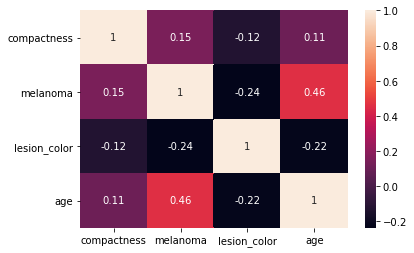

In [389]:

# new_df4.info()
# new_df4
corrMatrix = new_df4.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

In [298]:

new_df4.to_csv("dataframe.csv", index=False) 

In [381]:
from sklearn import preprocessing
scaled_features = new_df4.copy()
col_names = ["compactness","lesion_color","age"]
features = scaled_features[col_names]
scaler = StandardScaler().fit(features.values)
s_features = scaler.transform(features.values)
scaled_features[col_names] =s_features
scaled_features
#Fit scaler on our data
# scaler = preprocessing.StandardScaler().fit(new_df2["perimeter","area"])
# # new_df3 = [StandardScaler().fit_transform(X) for X in new_df2["lesion_color"]]
# #Apply to data itself
# df2 = scaler.transform(new_df2)
# df2
# new_df3

,compactness,melanoma,lesion_color,age
0,-0.007874,1.0,-0.372837,0.444561
1,-0.351896,1.0,1.010850,1.576583
2,-0.221540,1.0,-1.133865,-1.253472
3,-0.284197,1.0,-0.372837,0.161555
4,-0.329926,1.0,0.111453,-1.253472
...,...,...,...,...
743,-0.347064,0.0,-0.580390,-2.102489
744,-0.354526,0.0,-0.718759,-2.102489
745,-0.352060,0.0,-0.649574,-2.102489
746,0.140224,0.0,-0.857127,-2.102489


In [96]:
scaled_features['lesion_color'].type()

AttributeError: 'Series' object has no attribute 'type'

In [390]:
# Split the data before feature selection
from sklearn.model_selection import train_test_split

# Add the noisy data to the informative features
X = scaled_features[["compactness","lesion_color","age"]]
y = scaled_features['melanoma']
print(X.shape)
print(y.shape)
# Split dataset to select feature and evaluate the classifier
X_dev, X_test, y_dev, y_test = train_test_split(
        X, y, stratify=y, random_state=0)

X_train, X_val, y_train, y_val = train_test_split(
        X_dev, y_dev, stratify=y_dev)


(748, 3)
(748,)


In [83]:
# X_train = np.asarray(X_train)
# X_train.shape
# x= np.unique(map(len, X_train))


In [360]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# # # Select features that had good scores on training set
# X_train1 = X_train[:, [0,1]]
# X_train2 = selector.transform(X_train)



# Train a classifier
knn1 = KNeighborsClassifier(n_neighbors=1) # other hyperparameters possible
knn1trained = knn1.fit(X_train, y_train)

knn2 = KNeighborsClassifier(n_neighbors=3)
knn2trained = knn2.fit(X_train, y_train)

tree1 = DecisionTreeClassifier() # various hyperparameters
tree1trained = tree1.fit(X_train, y_train)



In [361]:

y_val_knn1 = knn1trained.predict(X_val)
y_val_knn2 = knn2trained.predict(X_val)
y_val_tree1 = tree1trained.predict(X_val)

In [362]:
from sklearn.metrics import accuracy_score

acc_knn1 = accuracy_score(y_val, y_val_knn1)
acc_knn2 = accuracy_score(y_val, y_val_knn2)
acc_tree1 = accuracy_score(y_val,y_val_tree1)
print(acc_knn1)
print(acc_knn2)
print(acc_tree1)

0.7021276595744681
0.723404255319149
0.6666666666666666


In [363]:
from sklearn.metrics import roc_auc_score

auc1 = roc_auc_score(y_val, y_val_knn1)
auc2 = roc_auc_score(y_val, y_val_knn2)
auc3 = roc_auc_score(y_val, y_val_tree1)
print(auc1)
print(auc2)
print(auc3)

0.70261569416499
0.7240442655935614
0.6665995975855131


In [364]:
y_test_knn1 = knn2trained.predict(X_test)
y_test_knn2 = tree1trained.predict(X_test)
acc_test = accuracy_score(y_test, y_test_knn1)
auc_test = roc_auc_score(y_test, y_test_knn1)

print(acc_test)
print(auc_test)

0.732620320855615
0.7322123083962481


In [391]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn import decomposition, datasets
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier  
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

#Running GridSearch algorithm to find the best hyperparameters for the classifiers 
clf_svc = svm.SVC()
clf_rf = RandomForestClassifier()
lr = LogisticRegression()
best_models=[]
models = [
          clf_rf, 
          lr,
          clf_svc,
          ]

for model in models:
# finding the best hyperparameters for each model using gridsearch
    if(model==clf_rf):
        grid_search = GridSearchCV(model, param_grid={ 'bootstrap': [True, False],
            'criterion': ['gini', 'entropy'], 'n_estimators': [3,10,30,100,300,1000]}, 
            cv=10, scoring='accuracy', return_train_score=True,n_jobs=-1)
        grid_search.fit(X,y)
        best_params= grid_search.best_params_
        best_rf = RandomForestClassifier(bootstrap = best_params['bootstrap'],criterion=best_params['criterion'],
                                         n_estimators= best_params['n_estimators'])
        print(best_params)
        best_models.append(best_rf)
    if(model==lr):
        grid_search = GridSearchCV(model, param_grid={ 'penalty':["l1","l2"], 'C': [0.001, 0.01, 0.1, 1, 10]}
            , cv=10, scoring='accuracy', return_train_score=True,n_jobs=-1)
        grid_search.fit(X,y)
        best_params= grid_search.best_params_
        best_lr = LogisticRegression(penalty= best_params['penalty'], C=best_params['C']) 
        print(best_params)
        best_models.append(best_lr)
    if(model==clf_svc):
        grid_search = GridSearchCV(model, param_grid={  'decision_function_shape':('ovo','ovr'),
            'shrinking':(True,False),'kernel':('linear', 'rbf','poly'), 'C': [0.001, 0.01, 0.1, 1, 10], 
            'gamma' : [0.001, 0.01, 0.1, 1]}, cv=10, scoring='accuracy', return_train_score=True,n_jobs=-1)
        grid_search.fit(X,y)
        best_params = grid_search.best_params_
        best_svc = svm.SVC(decision_function_shape=best_params['decision_function_shape'],
            shrinking= best_params['shrinking'],kernel=best_params['kernel'], C= best_params['C'], 
            gamma = best_params['gamma'])
        print(best_params)
        best_models.append(best_svc)

{'bootstrap': True, 'criterion': 'entropy', 'n_estimators': 10}
{'C': 10, 'penalty': 'l2'}
{'C': 10, 'decision_function_shape': 'ovo', 'gamma': 1, 'kernel': 'rbf', 'shrinking': True}


In [392]:
kfold = KFold(n_splits=10)
models_table = pd.DataFrame(columns=['Classifier_name', 'train_score','vald_score'])
metrics_table = pd.DataFrame(columns=['Classifier_name', 'test_score',"auc_score"])
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)

for i, model in enumerate(best_models):
# training the models 
    print(model)
    cv_result = cross_validate(model, X_train, y_train, cv=kfold, scoring='accuracy',return_train_score=True)
    modelx = model.fit(X_train,y_train)
    models_table.loc[i, 'Classifier_name'] = model.__class__.__name__
    models_table.loc[i, 'train_score'] = cv_result['train_score'].mean()
    models_table.loc[i, 'vald_score'] = cv_result['test_score'].mean()
    metrics_table.loc[i, 'Classifier_name']= model.__class__.__name__
    y_pred_val = modelx.predict(X_test)

    print(model.__class__.__name__)
    print(confusion_matrix( y_test,y_pred_val))
    print()
    metrics_table.loc[i,"Classifier_name"] = model.__class__.__name__
    metrics_table.loc[i,"test_precision"] = precision_score(y_test,y_pred_val)
    metrics_table.loc[i,"test_score"] = accuracy_score(y_test,y_pred_val)
    metrics_table.loc[i,"test_recall"] = recall_score(y_test,y_pred_val)
    metrics_table.loc[i,"auc_score"] = roc_auc_score(y_test,y_pred_val)
models_table

RandomForestClassifier(criterion='entropy', n_estimators=10)
RandomForestClassifier
[[77 17]
 [33 60]]

LogisticRegression(C=10)
LogisticRegression
[[63 31]
 [28 65]]

SVC(C=10, decision_function_shape='ovo', gamma=1)
SVC
[[72 22]
 [38 55]]



,Classifier_name,train_score,vald_score
0,RandomForestClassifier,0.981579,0.721836
1,LogisticRegression,0.703109,0.698778
2,SVC,0.804711,0.73963


In [393]:
metrics_table

,Classifier_name,test_score,auc_score,test_precision,test_recall
0,RandomForestClassifier,0.73262,0.732155,0.779221,0.645161
1,LogisticRegression,0.684492,0.684569,0.677083,0.698925
2,SVC,0.679144,0.678678,0.714286,0.591398


In [ ]:
import cv2
def extract_color_histogram(img, n_bins=8):
    """Extract Color histogram of an image.
    :param img: ndarray, BGR image
    :return feature: ndarray, contains n_bins*n_bins*n_bins HSV histogram features of the image
    """
    
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV) # convert the image to HSV color-space
    hist  = cv2.calcHist([hsv], [0, 1, 2], None, [n_bins, n_bins, n_bins], [0, 180, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    feature = hist.flatten()
    return feature
extract_color_histogram(im,8)

array([2.77986564e-03, 9.90755507e-04, 2.49322475e-04, 9.85963634e-05,
       5.75024424e-05, 2.96224716e-05, 9.87415660e-06, 7.69603412e-06,
       4.13988542e-04, 1.03707693e-03, 2.62246002e-04, 6.98451404e-05,
       2.30881014e-05, 4.35624588e-06, 2.03291461e-06, 1.45208196e-06,
       1.90222727e-05, 1.28073618e-04, 6.41820225e-05, 1.00193647e-05,
       1.74249828e-06, 1.45208190e-07, 0.00000000e+00, 0.00000000e+00,
       2.90416381e-07, 8.85769987e-06, 2.32333105e-06, 1.45208190e-07,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [ ]:
from sklearn import decomposition, datasets
from sklearn.preprocessing import StandardScaler

pca = decomposition.PCA(n_components=1)

X_std_pca = pca.fit_transform(new_arr.reshape(-1,1))

print(X_std_pca.shape)
print(X_std_pca)

(36632384, 1)
[[ 10.66743827]
 [ 29.66743827]
 [-33.33256173]
 ...
 [116.66743827]
 [116.66743827]
 [108.66743827]]
